In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [8]:
def readFile(filename):
    print("=====VA: House Price Index File=====")
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [9]:
VA_HPI = readFile("VA_HousePriceIndex.csv")

=====VA: House Price Index File=====
File read into dataframe.
(39, 1)


In [10]:
VA_HPI.rename(columns={'VA_House Price Index': 'VA_HousePriceIndex'}, inplace=True)

In [11]:
VA_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [12]:
VA_HPI.head()

,VA_HousePriceIndex
1977-01-01,75.9875
1978-01-01,84.6825
1979-01-01,92.7950
1980-01-01,102.1400
1981-01-01,106.5100


In [13]:
VA_HPI.VA_HousePriceIndex.describe()

count     39.000000
mean     246.403077
std      124.212378
min       75.987500
25%      145.320000
50%      201.302500
75%      391.898750
max      464.485000
Name: VA_HousePriceIndex, dtype: float64

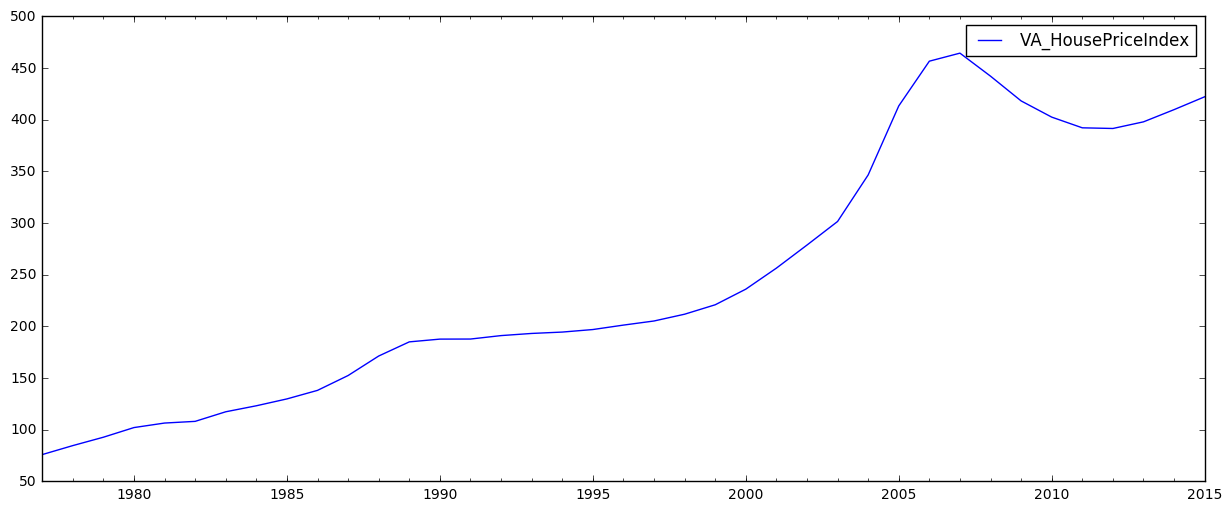

In [14]:
VA_HPI.plot(figsize=(15,6))
plt.show()

There is an overall increasing trend in the data. We can see in year 2007 for the crisis reason.

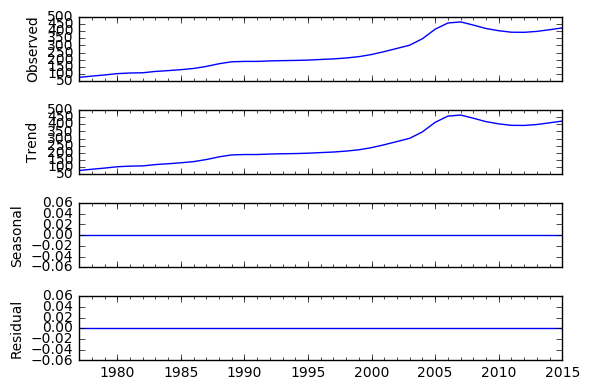

In [15]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(VA_HPI, model='additive')
fig = decomposition.plot()
plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [16]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [17]:
meanVarianceCheck(VA_HPI)

('mean1=144.175526, mean2=343.519250',
 'variance1=1733.346605, variance2=8308.379572')

In [18]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

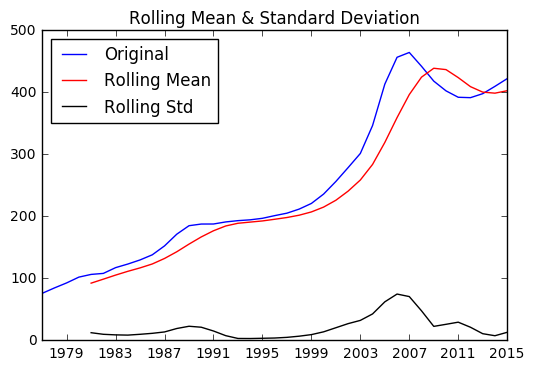

Results of Dickey-Fuller Test:
Test Statistic                 -0.621165
p-value                         0.866128
#Lags Used                      4.000000
Number of Observations Used    34.000000
Critical Value (5%)            -2.951230
Critical Value (1%)            -3.639224
Critical Value (10%)           -2.614447
dtype: float64


In [19]:
test_stationarity(VA_HPI.VA_HousePriceIndex)

# Estimating & Eliminating Trend

In [20]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

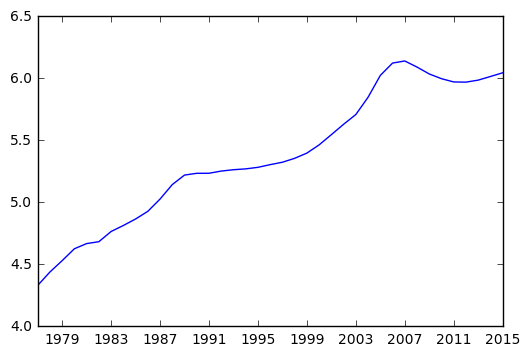

In [21]:
ts_log = logTransform(VA_HPI)

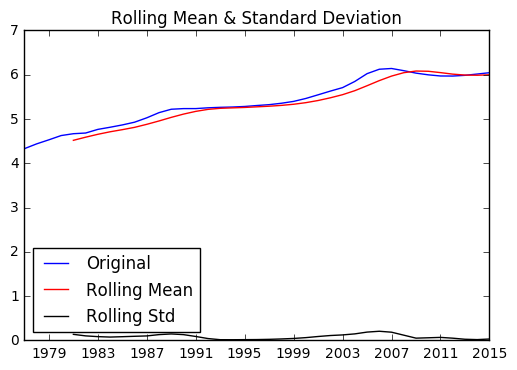

Results of Dickey-Fuller Test:
Test Statistic                 -1.589458
p-value                         0.488887
#Lags Used                      4.000000
Number of Observations Used    34.000000
Critical Value (5%)            -2.951230
Critical Value (1%)            -3.639224
Critical Value (10%)           -2.614447
dtype: float64


In [22]:
test_stationarity(ts_log.VA_HousePriceIndex)

In [23]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

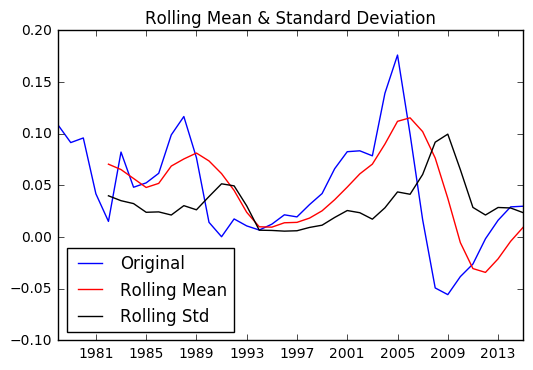

Results of Dickey-Fuller Test:
Test Statistic                 -2.499328
p-value                         0.115638
#Lags Used                      3.000000
Number of Observations Used    34.000000
Critical Value (5%)            -2.951230
Critical Value (1%)            -3.639224
Critical Value (10%)           -2.614447
dtype: float64


In [24]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.VA_HousePriceIndex)

In [25]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

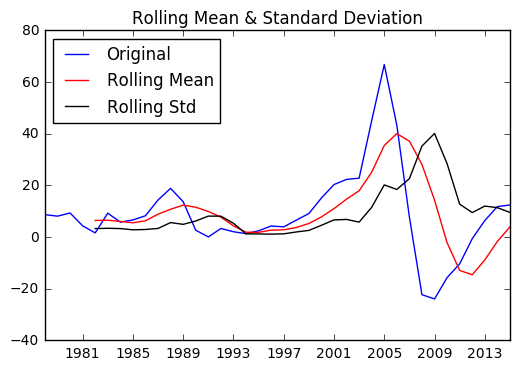

Results of Dickey-Fuller Test:
Test Statistic                 -2.896303
p-value                         0.045780
#Lags Used                      3.000000
Number of Observations Used    34.000000
Critical Value (5%)            -2.951230
Critical Value (1%)            -3.639224
Critical Value (10%)           -2.614447
dtype: float64


In [26]:
ts_first_diff = firstDifference(VA_HPI)
test_stationarity(ts_first_diff.VA_HousePriceIndex)

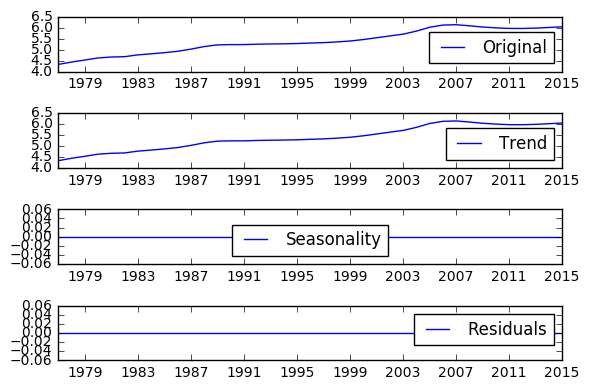

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

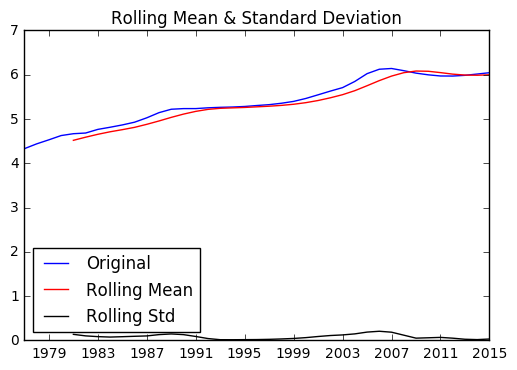

Results of Dickey-Fuller Test:
Test Statistic                 -1.589458
p-value                         0.488887
#Lags Used                      4.000000
Number of Observations Used    34.000000
Critical Value (5%)            -2.951230
Critical Value (1%)            -3.639224
Critical Value (10%)           -2.614447
dtype: float64


In [28]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.VA_HousePriceIndex)

In [62]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

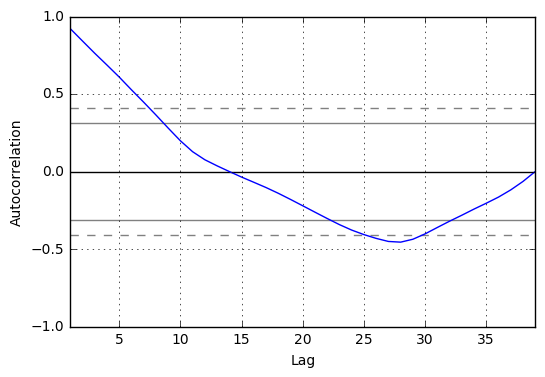

In [63]:
autocorrelation_plot(ts_log)
plt.show()

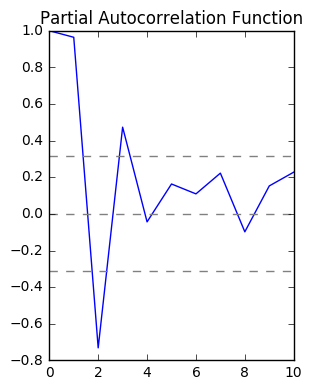

In [49]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [64]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [65]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [66]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    #plt.plot(ts_log_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                       5.128503
ar.L1.VA_HousePriceIndex    1.874806
ar.L2.VA_HousePriceIndex   -0.880616
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     VA_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                  73.961
Method:                       css-mle   S.D. of innovations              0.033
Date:                Wed, 26 Apr 2017   AIC                           -139.921
Time:                        22:48:37   BIC                           -133.267
Sample:                    01-01-1977   HQIC                          -137.534
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.1285

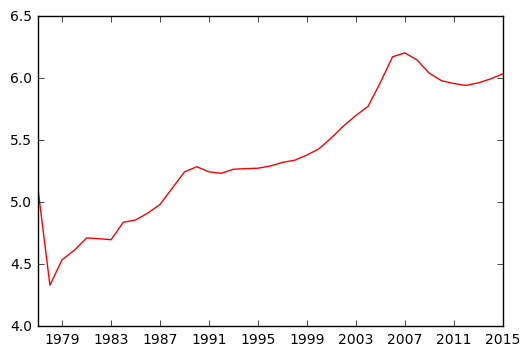

In [67]:
model_AR = AR_Model(ts_log)

In [68]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 1))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 1))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log_diff)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       5.368776
ma.L1.VA_HousePriceIndex    0.999934
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     VA_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 1)   Log Likelihood                  -6.839
Method:                       css-mle   S.D. of innovations              0.275
Date:                Wed, 26 Apr 2017   AIC                             19.679
Time:                        22:48:53   BIC                             24.670
Sample:                    01-01-1977   HQIC                            21.469
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.3688      0.087     61.729      0.000    

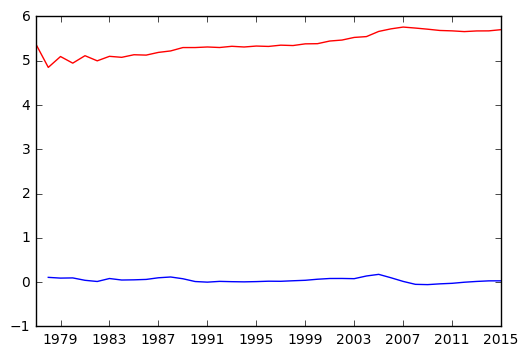

In [69]:
model_MA = MA_Model(ts_log)

In [70]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(2, 0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                       5.134503
ar.L1.VA_HousePriceIndex    1.781334
ar.L2.VA_HousePriceIndex   -0.787530
ma.L1.VA_HousePriceIndex    0.530041
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     VA_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 1)   Log Likelihood                  77.798
Method:                       css-mle   S.D. of innovations              0.029
Date:                Wed, 26 Apr 2017   AIC                           -145.597
Time:                        22:49:05   BIC                           -137.279
Sample:                    01-01-1977   HQIC                          -142.612
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

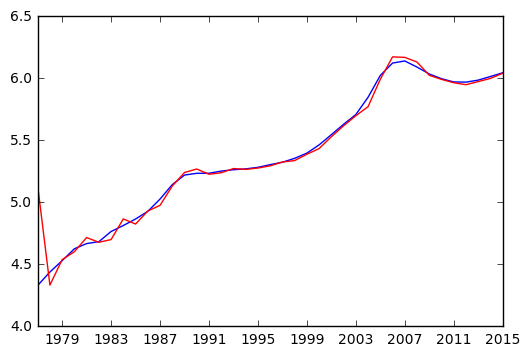

In [71]:
model_Combined = Combined_Model(ts_log)

In [72]:
aic_metric

,AIC,Modelname
0,-139.921393,"ARIMA(ts, order=(2, 0, 0))"
0,19.678847,"ARIMA(ts, order=(0, 0, 1))"
0,-145.596758,"ARIMA(ts, order=(2, 0, 1))"


In [73]:
aic_dict

{'ARIMA(ts, order=(0, 0, 1))': 19.678847102408284,
 'ARIMA(ts, order=(2, 0, 0))': -139.92139275223096,
 'ARIMA(ts, order=(2, 0, 1))': -145.59675753225488}

In [74]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 0, 1))


In [75]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output    

In [77]:
output_forecast = forecast(model_AR,5)

[ 431.22120134  436.88245062  439.49412277  439.35716438  436.80187216]


In [40]:
#AR model
#model = ARIMA(ts_log, order=(2, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
#print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.aic)



#MA model
#model = ARIMA(ts_log, order=(0, 1, 1))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')


#Combined model
#model = ARIMA(ts_log, order=(2, 1, 1))  
#results_ARIMA = model.fit(disp=-1) 
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')